In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
import numpy as np

In [ ]:
!pip install -U sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 88.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=416991b8f40e94ce76d1440a0de639d7b975609d1771db833ec82d3c8304138a
  Stored in directory: /root/.cache/pip/wheels/5e/6f/8c/d88aec621f3f542d26fac0342bef5e693335d125f4e54aeffe
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('all-MiniLM-L6-v2')

embedding = encoder.encode('This framework')

embedding.shape

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

(384,)

In [ ]:
class SCM(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(384, 384)
    self.l2 = nn.Linear(384, 384)
    # self.l3 = nn.Linear(200, 128)
    self.relu = nn.ReLU()
    # self.l4 = nn.Linear(35, 10)

  def forward(self, x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    # x = self.relu(x)
    # x = self.l3(x)
    # x = self.l4(x)
    return x

# Download data

In [ ]:
!wget https://raw.githubusercontent.com/jacoxu/StackOverflow/master/rawText/title_StackOverflow.txt
!wget https://raw.githubusercontent.com/jacoxu/StackOverflow/master/rawText/label_StackOverflow.txt

--2023-01-23 13:06:03--  https://raw.githubusercontent.com/jacoxu/StackOverflow/master/rawText/title_StackOverflow.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1030059 (1006K) [text/plain]
Saving to: ‘title_StackOverflow.txt’

title_StackOverflow 100%[===================>]   1006K  --.-KB/s    in 0.005s  

2023-01-23 13:06:04 (190 MB/s) - ‘title_StackOverflow.txt’ saved [1030059/1030059]

--2023-01-23 13:06:04--  https://raw.githubusercontent.com/jacoxu/StackOverflow/master/rawText/label_StackOverflow.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiti

In [ ]:
df_text = pd.read_csv("title_StackOverflow.txt", sep="\n", header=None)
df_label = pd.read_csv("label_StackOverflow.txt", sep="\n", header=None)

In [ ]:
df = pd.concat([df_text, df_label],  axis=1)
df.columns = ['text', 'label']

In [ ]:
df.head()

,text,label
0,How do I fill a DataSet or a DataTable from a ...,18
1,How do you page a collection with LINQ?,18
2,Best Subversion clients for Windows Vista (64bit),3
3,"Best Practice: Collaborative Environment, Bin ...",3
4,Visual Studio Setup Project - Per User Registr...,7


In [ ]:
df['text'][0]

'How do I fill a DataSet or a DataTable from a LINQ query resultset ?'

In [ ]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
import numpy as np

from sklearn.metrics import pairwise_distances



In [ ]:
import matplotlib.pyplot as plt

def arg_best_k(K, inertia, verbose=False):

  #slope of line between first and last point
  slope = (inertia[-1] - inertia[0]) / (K[-1] - K[0])
  intercept = inertia[0] - slope * K[0]
  line = [slope * x + intercept for x in K]

  # distance from each point to the line
  start_line = np.array([K[0], inertia[0]])
  end_line = np.array([K[-1], inertia[-1]])

  distances = []
  for x, y in zip(K, inertia):
      point = np.array([x, y])
      diff = end_line - start_line
      d = np.linalg.norm(np.cross(diff, start_line-point))/np.linalg.norm(diff)
      d = -d if y > (slope * x + intercept) else d
      distances.append(d)

  best_idx = np.argmax(distances)
  best_k = K[best_idx]
  best_intertia = inertia[best_idx]

  if verbose:

    plt.plot(K, inertia, 'bx-')
    plt.plot(K, line, 'gx-')

    print(best_k)
    print(distances)
  
  return best_idx

4
[0.0, -0.49987221132566884, 1.7784398272290127, 1.5699504124549901, 0.8414934210758747, 0.0]


2

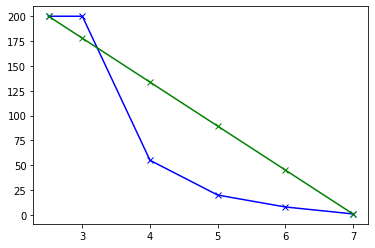

In [ ]:
arg_best_k([2.5,3,4,5,6,7], [200, 200, 55, 20, 8, 1],True)

In [ ]:
def kmeans_loss(outputs, loss_type="inter", verbose=False, K=range(2, 30, 2)):

  loss_fn = torch.nn.PairwiseDistance()
  loss_hist = []

  for k in K:
    km = KMeans(k)
    km_inputs = outputs.detach().numpy()
    km.fit(km_inputs)
    predicted_clusters = km.predict(km_inputs)
    centers = km.cluster_centers_[predicted_clusters]
    centers = torch.from_numpy(centers)

    barycenter = [np.mean(km.cluster_centers_, axis=0)]
    
    intra_class = torch.sum(loss_fn(outputs, centers)) / outputs.shape[0]
    inter_class = np.sum(pairwise_distances(km.cluster_centers_, barycenter)) / km.cluster_centers_.shape[0]

    if loss_type == "inter":
      loss = - inter_class
    elif loss_type == "intra":
      loss = intra_class
    elif loss_type == "intra_inter":
      loss = intra_class - inter_class
    else :
      raise ValueError("Uknown loss type")

    loss_hist.append(intra_class)

    # if verbose:
    #   print(f"k : {k} - loss : {loss.item()} - intra class : {intra_class} - inter class {inter_class}")

  arg_best = arg_best_k(K, [l.item() for l in loss_hist])
  best_loss = loss_hist[arg_best]
  best_k = K[arg_best]

  if verbose:
    print(f"best_k : {best_k}")
  return best_loss, best_k



In [ ]:
from sklearn import metrics
def evaluate(inputs, labels, k=10):

  km = KMeans(k)
  km.fit(inputs)
  predicted = km.predict(inputs)

  print(f"Homogeneity : {metrics.homogeneity_score(predicted, labels)}")
  print(f"Completeness : {metrics.completeness_score(predicted, labels)}")

  print(f"V-measure : {metrics.v_measure_score(predicted, labels)}")
  print(f"Adjusted Rand Index : {metrics.adjusted_rand_score(predicted, labels)}")
  print(f"Adjusted Mutual Information : {metrics.adjusted_mutual_info_score(predicted, labels)}")

prepare data

In [ ]:
df.text.shape

(20000,)

In [ ]:
inputs = df.text.apply(encoder.encode).values
inputs = np.stack(inputs, axis=0)

labels = df.label.values

In [ ]:
inputs.shape

(20000, 384)

shuffle

In [ ]:
new_order = np.arange(inputs.shape[0])
np.random.shuffle(new_order)

inputs = inputs[new_order]
labels = labels[new_order]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(inputs, labels, test_size=0.3, random_state=42)

In [ ]:
X_train.shape

(14000, 384)

# Training

In [ ]:
n_epochs = 5
batch_size = 64
learning_rate=1e-3

k : 1 - loss : 0.9869033098220825 - intra class : 0.9869033098220825 - inter class 0.0
k : 3 - loss : 0.9605194330215454 - intra class : 0.9605194330215454 - inter class 0.2609930833180745
k : 5 - loss : 0.9404909014701843 - intra class : 0.9404909014701843 - inter class 0.32984931468963624
k : 7 - loss : 0.9223504066467285 - intra class : 0.9223504066467285 - inter class 0.3928397723606655
k : 9 - loss : 0.9061627984046936 - intra class : 0.9061627984046936 - inter class 0.4398301972283257
k : 11 - loss : 0.8936848640441895 - intra class : 0.8936848640441895 - inter class 0.4705086621371182
k : 13 - loss : 0.8835040330886841 - intra class : 0.8835040330886841 - inter class 0.470312448648306
k : 15 - loss : 0.872538685798645 - intra class : 0.872538685798645 - inter class 0.49832436243693035
k : 17 - loss : 0.8640892505645752 - intra class : 0.8640892505645752 - inter class 0.49971692702349496
k : 19 - loss : 0.8588285446166992 - intra class : 0.8588285446166992 - inter class 0.4953016

(tensor(0.9062), 9)

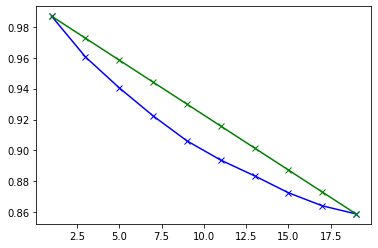

In [ ]:
kmeans_loss(torch.from_numpy(inputs), loss_type="intra", K=range(1,20,2), verbose=True)

In [ ]:
batches = gen_batches(len(inputs), batch_size)
model = SCM()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


for epoch in range(n_epochs):  
  for idx, batch in enumerate(batches):

    batch_input = torch.from_numpy(X_train[batch])

    optimizer.zero_grad()

    outputs = model(batch_input)

    if batch_input.shape[0] > 50:

      loss, k = kmeans_loss(outputs, loss_type="intra_inter", K=range(2,20,2))

      loss.backward()
      optimizer.step()

 
  print("#"*10)
  print(f"EPOCH {epoch} - best K : {k}")
  result = model(torch.from_numpy(X_train)).detach().numpy()
  evaluate(result, y_train, k)
  print("\n\n")

##########
EPOCH 0 - best K : 6
Homogeneity : 0.53171827168363
Completeness : 0.30664985806185124
V-measure : 0.38897311754963404
Adjusted Rand Index : 0.1881352352915016
Adjusted Mutual Information : 0.3880922156187636



##########
EPOCH 1 - best K : 6
Homogeneity : 0.5482129801628768
Completeness : 0.31698447631949556
V-measure : 0.4017002202826518
Adjusted Rand Index : 0.20115716319189358
Adjusted Mutual Information : 0.4008384612262191



##########
EPOCH 2 - best K : 6
Homogeneity : 0.5278084024065777
Completeness : 0.3092614777994224
V-measure : 0.3900052083657337
Adjusted Rand Index : 0.20214252960431495
Adjusted Mutual Information : 0.38913099271326446



##########
EPOCH 3 - best K : 6
Homogeneity : 0.5429533267957571
Completeness : 0.3050839042047829
V-measure : 0.3906581331208546
Adjusted Rand Index : 0.18503345420362363
Adjusted Mutual Information : 0.3897708631372065



##########
EPOCH 4 - best K : 6
Homogeneity : 0.5346525596630199
Completeness : 0.3096008480851431
V-me

In [ ]:
X_train.shape

(11, 384)

# Compare loss with and without transformation

Evaluate

without transformation

In [ ]:
evaluate(inputs, labels, k=6)

Homogeneity : 0.7638369111601598
Completeness : 0.4202150954409014
V-measure : 0.5421650379122159
Adjusted Rand Index : 0.2444910494176717
Adjusted Mutual Information : 0.5416955058058052


with transofmation

In [ ]:
result = model(torch.from_numpy(inputs)).detach().numpy()

In [ ]:
evaluate(result, labels, k=15)

Homogeneity : 0.6513947483878298
Completeness : 0.5648699203101263
V-measure : 0.6050546547671602
Adjusted Rand Index : 0.4228417656831512
Adjusted Mutual Information : 0.6041101228562124


In [ ]:
def cons_loss(feat1,feat2,temperature,batch_size):
  all = torch.cat([feat1, feat2], dim=0)
  #Calcul des simulutudes entre les paires 
  sim_dot_product = torch.mm(all,all.T)
  sim_norm = torch.mm(all.norm(p=2, dim=1).reshape(2 * batch_size,1), all.norm(p=2, dim=1).reshape(1,2* batch_size))
  sim = sim_dot_product/sim_norm 
  #Diviser par la température 
  sim_t = sim / temperature
  #Calculer la somme des simultudes entre les paires négatives de chaque élement 
  sim_neg = torch.sum(torch.exp(sim_t), dim=1) - math.exp(1/temperature)
  #Récupérer la valeur de la simulutude positive (paires +)
  diag_pos = torch.exp((sim_t[0:batch_size,batch_size : batch_size *2] * torch.eye(batch_size)).sum(axis = 0))
  sim_pos = diag_pos.repeat(2)

  loss = (- torch.log(sim_pos / sim_neg)).mean()
  return loss 

In [ ]:
class Contrastive(nn.Module):
  def __init__(self, temperature=0.5, batch_size = 64, emb_size = 384, cl_head_dim = 128):
        super(Contrastive, self).__init__()
        self.contrast_head = nn.Sequential(
            nn.Linear(emb_size, 2*emb_size),
            nn.ReLU(inplace=True),
            nn.Linear(2*emb_size, cl_head_dim))
  def forward(self, outputs_aug1, outputs_aug2):
          feat1 , feat2 = self.contrast_head(outputs_aug1),  self.contrast_head(outputs_aug2) 
          return feat1, feat2  
    

In [ ]:
df_text = pd.read_csv("/content/out30.csv", sep=",", header= 0)

echant = 10_000
org_inputs  =  np.stack(df_text.iloc[0:echant,1].apply(encoder.encode).values, axis = 0)
aug1_inputs =  np.stack(df_text.iloc[0:echant,2].apply(encoder.encode).values, axis = 0)
aug2_inputs =  np.stack(df_text.iloc[0:echant,3].apply(encoder.encode).values, axis = 0)


In [ ]:
n_epochs = 10
batch_size = 128
learning_rate=1e-3

model = SCM() 
#lossfn=PairConLoss(batch_size=batch_size)
cotrastive=Contrastive(batch_size=batch_size)
#CL_loss = PairConLoss()
parameters = list(cotrastive.parameters())+list(model.parameters())
# optimizer = torch.optim.SGD(parameters, lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

clust_weight = 1
# contr_weight = 0.1

#print(CL_loss.contrast_head.state_dict())
for epoch in range(n_epochs):
    batches = gen_batches(echant, batch_size)
    ls=0
    for idx, batch in enumerate(batches):
        optimizer.zero_grad()
        bc_org_inputs = torch.from_numpy(org_inputs[batch])
        bc_aug1_inputs = torch.from_numpy(aug1_inputs[batch])
        bc_aug2_inputs = torch.from_numpy(aug2_inputs[batch])
        if bc_org_inputs.shape[0] >= batch_size : 
            outputs_org = model(bc_org_inputs)
            outputs_aug1= model(bc_aug1_inputs)
            outputs_aug2= model(bc_aug2_inputs)

            #loss_contr = CL_loss(outputs_aug1, outputs_aug2)
            feat1, feat2 = cotrastive(outputs_aug1, outputs_aug2)
            loss_contr= cons_loss(feat1, feat2, 0.5, batch_size)
            loss_clust, k = kmeans_loss(outputs_org, loss_type="intra_inter", K=range(2,20,2))
            #if epoch>40:
            #print("contrastive: "+str(loss_contr))
            #print("kmeans: "+str(loss_clust))
            loss = loss_contr + clust_weight * loss_clust
            ls+=loss.item()
            if math.isnan(loss.item()):
              input()
            #print("somme:" +str(loss.item()))
            loss.backward()
            #loss_contr.backward()
            
            optimizer.step()
    
    print(f"epoch {epoch} - best K : {k} \n loss {loss.item()} - loss_clust : {loss_clust} - loss_contr : {loss_contr}\n\n")

epoch 0 - best K : 6 
 loss 4.743119239807129 - loss_clust : 0.16495710611343384 - loss_contr : 4.57816219329834


epoch 1 - best K : 8 
 loss 4.53792667388916 - loss_clust : 0.12868763506412506 - loss_contr : 4.409238815307617


epoch 2 - best K : 8 
 loss 4.393481254577637 - loss_clust : 0.11167774349451065 - loss_contr : 4.281803607940674


epoch 3 - best K : 8 
 loss 4.2992262840271 - loss_clust : 0.10732591152191162 - loss_contr : 4.191900253295898


epoch 4 - best K : 8 
 loss 4.220001697540283 - loss_clust : 0.10242484509944916 - loss_contr : 4.117577075958252


epoch 5 - best K : 6 
 loss 4.184298515319824 - loss_clust : 0.10029243677854538 - loss_contr : 4.084006309509277


epoch 6 - best K : 8 
 loss 4.129191875457764 - loss_clust : 0.0900462195277214 - loss_contr : 4.039145469665527


epoch 7 - best K : 8 
 loss 4.115389823913574 - loss_clust : 0.08541738241910934 - loss_contr : 4.029972553253174


epoch 8 - best K : 8 
 loss 4.127695083618164 - loss_clust : 0.08400247991085

with tranformation

In [ ]:
result = model(torch.from_numpy(org_inputs)).detach().numpy()

In [ ]:
labels = df.label.values[:10_000]

In [ ]:
km = KMeans(8)
km.fit(result)
res = km.predict(result)
km.inertia_

82.35124206542969

In [ ]:
res.shape

(10000,)

In [ ]:
labels.shape

(10000,)

In [ ]:
evaluate(res.reshape(-1, 1), labels)

Homogeneity : 0.5457970229723472
Completeness : 0.4035926013139671
V-measure : 0.4640447602456573
Adjusted Rand Index : 0.3676386114239046
Adjusted Mutual Information : 0.46256026711092135


<ipython-input-14-0e96ea8953d6>:5: ConvergenceWarning: Number of distinct clusters (8) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  km.fit(inputs)


In [ ]:
label_code =  {
  1 : "wordpress",
  2 : "oracle",
  3 : "svn",
  4 : "apache",
  5 : "excel",
  6 : "matlab",
  7 : "visual-studio",
  8 : "cocoa",
  9 : "osx",
  10 : "bash",
  11 : "spring",
  12 : "hibernate",
  13 : "scala",
  14 : "sharepoint",
  15 : "ajax",
  16 : "qt",
  17 : "drupal",
  18 : "linq",
  19 : "haskell",
  20 : "magento"
}

In [ ]:
pred_true = pd.DataFrame({"pred":res, "true":labels})

In [ ]:
pred_true["true"] = pred_true.true.apply(lambda x : label_code[x])

In [ ]:
pred_true.groupby(by="pred").groups[0]

Int64Index([   6,   14,   15,   17,   42,   48,   62,   67,   86,   87,
            ...
            9932, 9933, 9936, 9941, 9943, 9945, 9973, 9976, 9978, 9984],
           dtype='int64', length=1482)

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
groups = pred_true.groupby(by="pred").groups

In [ ]:
for f in groups.values():
  print(f)
  break

Int64Index([   6,   14,   15,   17,   42,   48,   62,   67,   86,   87,
            ...
            9932, 9933, 9936, 9941, 9943, 9945, 9973, 9976, 9978, 9984],
           dtype='int64', length=1482)


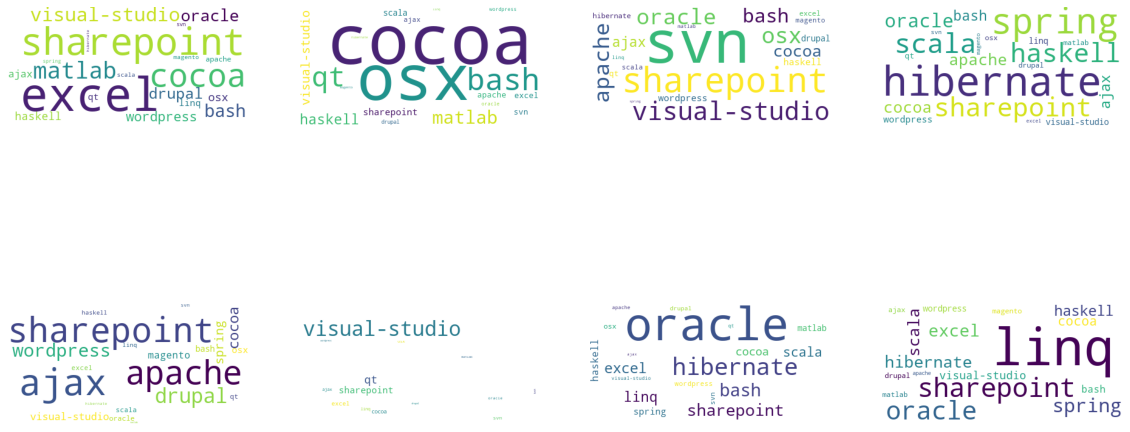

In [ ]:
fig, ax = plt.subplots(2,4, figsize=(20,10))

for idx, group in enumerate(groups.values()):

  freqs = pred_true.iloc[group].true.value_counts()
  wc = WordCloud(background_color="white").generate_from_frequencies(freqs)

  ax.flatten()[idx].axis('off')
  ax.flatten()[idx].imshow(wc)